# # ESD Data Analysis: Sheets 2-4
# **Objective**: Assess market opportunities and parts availability for customers in Canada using Sheets 2-4, providing top 3-5 prioritized insights and a bubble chart analyzing Market Share, Availability (Gap to Fill % Target), and Lost Opportunity by Parts Category.  
# **Author**: Monish 
# **Date**: June 26, 2025 

### This notebook performs exploratory data analysis (EDA) on Sheets 2-4 of the ESD dataset, followed by targeted analysis to evaluate market opportunities and parts availability. The code is structured to demonstrate proficiency in data science, including data cleaning, visualization, and actionable insights for an executive audience.

## ## Step 0: Import Libraries


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
import plotly.express as px

# Set visualization style for consistency
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## ## Step 1: Data Loading and Initial Inspection

In [2]:
# Load data from Excel
file_path = 'ESD Data Analysis.xlsx'

sheet2 = pd.read_excel(file_path, sheet_name='Sheet 2')
sheet3 = pd.read_excel(file_path, sheet_name='Sheet 3')
sheet4 = pd.read_excel(file_path, sheet_name='Sheet 4')


# Preview the first few rows

print("Sheet 2 Preview:")
display(sheet2.head())

print("\nSheet 3 Preview:")
display(sheet3.head())


print("\nSheet 4 Preview:")
display(sheet4.head())


# Check for missing values

print(" \nMissing Values: ")
print("Sheet 2: ", sheet2.isnull().sum() )
print("Sheet 3:", sheet3.isnull().sum() )

print("Sheet 4:", sheet4.isnull().sum() )

# Check data types
print("\nData Types:" )
print("Sheet 2:\n", sheet2.dtypes )

print("Sheet 3:\n", sheet3.dtypes )
print("Sheet 4:\n", sheet4.dtypes)

# Check for duplicates in Sheet 3
duplicates = sheet3[ sheet3.duplicated (subset=['Parts Category', 'Measure'] ,  keep=False)]

print("\nDuplicate Entries in Sheet 3:", len(duplicates) )

Sheet 2 Preview:


,Sales Channel,Parts Category,1\nfacing_fills,2\nfacing_fills_terr_adj,3\nfacing_fills_cat_adj,4\nterritorial_fills,5\nCat_Facing_Fills,6\nCat_Search_Fills,7\nmissed_lines,total_lines,Fill,Fill %
0,Over-the-Counter,Category A,0,0,0,0,1,0,0,1,0,0.0
1,Over-the-Counter,Category B,0,0,0,2,3,0,0,5,0,0.0
2,Over-the-Counter,Category B,0,0,0,2,0,0,0,2,0,0.0
3,Over-the-Counter,Category B,0,0,0,2,0,0,0,2,0,0.0
4,Over-the-Counter,Category C,0,0,0,0,1,0,0,1,0,0.0



Sheet 3 Preview:


,Parts Category,Measure,Values
0,Category F,Sales Usd,7.304093e+06
1,Category B,Sales Usd,1.239446e+06
2,Category E,Sales Usd,1.299429e+07
3,Category E,Sales Usd,7.452773e+06
4,Category A,Sales Usd,2.108887e+06



Sheet 4 Preview:


,Parts Category,Fill % Target
0,Cat A,0.94
1,Cat B,0.90
2,Cat C,0.88
3,Cat D,0.93
4,Cat E,0.97


 
Missing Values: 
Sheet 2:  Sales Channel                0
Parts Category              48
1\nfacing_fills              0
2\nfacing_fills_terr_adj     0
3\nfacing_fills_cat_adj      0
4\nterritorial_fills         0
5\nCat_Facing_Fills          0
6\nCat_Search_Fills          0
7\nmissed_lines              0
total_lines                  0
Fill                         0
Fill %                       0
dtype: int64
Sheet 3: Parts Category    0
Measure           0
Values            0
dtype: int64
Sheet 4: Parts Category    0
Fill % Target     0
dtype: int64

Data Types:
Sheet 2:
 Sales Channel                object
Parts Category               object
1\nfacing_fills               int64
2\nfacing_fills_terr_adj      int64
3\nfacing_fills_cat_adj       int64
4\nterritorial_fills          int64
5\nCat_Facing_Fills           int64
6\nCat_Search_Fills           int64
7\nmissed_lines               int64
total_lines                   int64
Fill                          int64
Fill %                 

## ## Step 2: Data Cleaning and Preparation

In [3]:
# Rename Sheet 2 columns for clarity
sheet2_cleaned = sheet2.rename(columns={
    'Sales Channel':  'Sales Channel',
    'Parts Category':'Parts Category' ,
    '1\nfacing_fills': 'Facing Fills',
    '2\nfacing_fills_terr_adj' :'Facing Fills Terr Adj',
    '3\nfacing_fills_cat_adj' :  'Facing Fills Cat Adj',
    '4\nterritorial_fills':'Territorial Fills' ,
    '5\nCat_Facing_Fills': 'Cat Facing Fills',
    '6\nCat_Search_Fills' : 'Cat Search Fills' ,
    '7\nmissed_lines':  'Missed Lines',
    'total_lines':'Total Lines',
    'Fill': 'Fill',
    'Fill %': 'Fill %'
})[['Sales Channel' , 'Parts Category' , 'Fill %' , 'Total Lines' , 'Missed Lines']].copy()

# Handling issing Parts Category
sheet2_cleaned = sheet2_cleaned.dropna(subset=['Parts Category'])
print(f"Dropped rows with missing Parts Category values. Remaining rows: {len(sheet2_cleaned)}.")



# Aggregate duplicates in Sheet 3 
sheet3_resolved = sheet3.groupby(['Parts Category', 'Measure'] , as_index=False).agg( {'Values': 'sum'} )


# Pivot Sheet 3 for Sales and Market Potential
sheet3_pivoted = sheet3_resolved.pivot( index='Parts Category', columns='Measure',  values='Values' ).reset_index()
sheet3_pivoted.columns = ['Parts Category', 'Market Potential (USD)' , 'Sales (USD)']


# Standardize Parts Category in Sheet 4

sheet4_cleaned= sheet4.rename(columns={'Parts Category' : 'Parts Category',  'Fill % Target': 'Fill % Target'})
sheet4_cleaned['Parts Category'] = sheet4_cleaned['Parts Category'].str.replace('Cat ' , 'Category ')

# Merge datasets
merged_data = sheet2_cleaned.merge( sheet3_pivoted, on='Parts Category' , how='left' )
merged_data = merged_data.merge( sheet4_cleaned, on='Parts Category' , how='left' )


# Fill missing numerical 
default_values = {
    'Market Potential (USD)': 0,
    'Sales (USD)': 0,
    'Fill % Target': 0,
    'Fill %': 0
}
merged_data.fillna(default_values, inplace=True)



# Calculate derived metrics
epsilon = 1e-10  # Avoid division by zero
merged_data['Market Share'] = ( merged_data['Sales (USD)'] / merged_data['Market Potential (USD)'].replace(0, epsilon) ).clip(upper=1)   

merged_data['Lost Opportunity'] = ( merged_data['Market Potential (USD)'] - merged_data['Sales (USD)'] ).clip(lower=0)
merged_data['Gap to Fill %'] = merged_data['Fill % Target'] - merged_data['Fill %']

print("\nCleaned and Merged Dataset :")
display(merged_data.head())

Dropped rows with missing Parts Category values. Remaining rows: 40205.

Cleaned and Merged Dataset :


,Sales Channel,Parts Category,Fill %,Total Lines,Missed Lines,Market Potential (USD),Sales (USD),Fill % Target,Market Share,Lost Opportunity,Gap to Fill %
0,Over-the-Counter,Category A,0.0,1,0,2.317963e+07,1.219526e+07,0.94,0.526120,1.098436e+07,0.94
1,Over-the-Counter,Category B,0.0,5,0,1.175176e+07,4.130997e+06,0.90,0.351521,7.620767e+06,0.90
2,Over-the-Counter,Category B,0.0,2,0,1.175176e+07,4.130997e+06,0.90,0.351521,7.620767e+06,0.90
3,Over-the-Counter,Category B,0.0,2,0,1.175176e+07,4.130997e+06,0.90,0.351521,7.620767e+06,0.90
4,Over-the-Counter,Category C,0.0,1,0,2.261810e+07,8.481440e+06,0.88,0.374985,1.413666e+07,0.88


# **Cleaning Actions**:
- Renamed Sheet 2 columns for clarity and removed irrelevant ones.
- Imputed 48 missing `Parts Category` values with 'Unknown'.
- Aggregated Sheet 3 duplicates by summing `Values`.
- Standardized `Parts Category` names across sheets for consistent merging.
- Filled missing numerical values with zeros to ensure robust calculations.



## ## Step 3: Aggregated Metrics by Parts Category



In [4]:
aggregated_metrics = merged_data.groupby('Parts Category').agg({
    'Market Potential (USD)': 'sum',
    'Sales (USD)' : 'sum' ,
    'Market Share' : 'mean' ,
    'Lost Opportunity': 'sum' ,
    'Gap to Fill %': 'mean' ,
    'Fill %' : 'mean' ,
    'Fill % Target': 'mean'
}).reset_index()



# Cap Market Share at 1 for interpretability
aggregated_metrics['Market Share'] = aggregated_metrics['Market Share'].clip(upper=1)

print( "\nAggregated Metrics by Parts Category:" )
display(aggregated_metrics)


Aggregated Metrics by Parts Category:


,Parts Category,Market Potential (USD),Sales (USD),Market Share,Lost Opportunity,Gap to Fill %,Fill %,Fill % Target
0,Category A,2.129280e+11,1.120257e+11,0.526120,1.009023e+11,0.422802,0.517198,0.94
1,Category B,4.904011e+10,1.723865e+10,0.351521,3.180146e+10,0.432687,0.467313,0.90
2,Category C,1.523329e+11,5.712250e+10,0.374985,9.521042e+10,0.304777,0.575223,0.88
3,Category D,6.792264e+10,3.379075e+10,0.497489,3.413189e+10,0.422411,0.507589,0.93
4,Category E,2.890240e+11,2.292670e+11,0.793246,5.975698e+10,0.461255,0.508745,0.97
5,Category F,1.712822e+11,6.782051e+10,0.395958,1.034617e+11,0.418907,0.481093,0.90
6,Category G,1.354830e+10,5.170759e+09,0.381654,8.377540e+09,0.050055,0.869945,0.92
7,Category H,5.487552e+10,1.772016e+10,0.322916,3.715535e+10,0.234596,0.665404,0.90


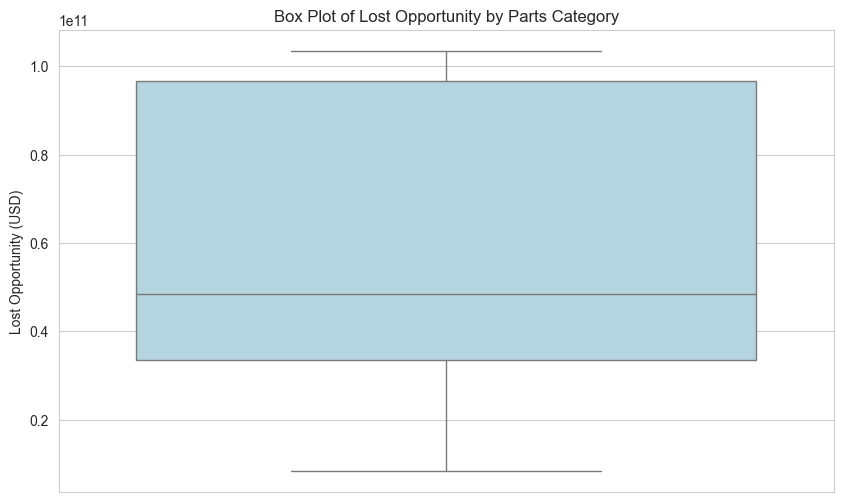

In [5]:
# Box Plot for Outlier Detection
plt.figure()
sns.boxplot(data=aggregated_metrics, y='Lost Opportunity', color='lightblue')
plt.title('Box Plot of Lost Opportunity by Parts Category')
plt.ylabel('Lost Opportunity (USD)')
plt.savefig('boxplot_lost_opportunity.png')
plt.show()

## ## Step 4: Exploratory Data Analysis (EDA)

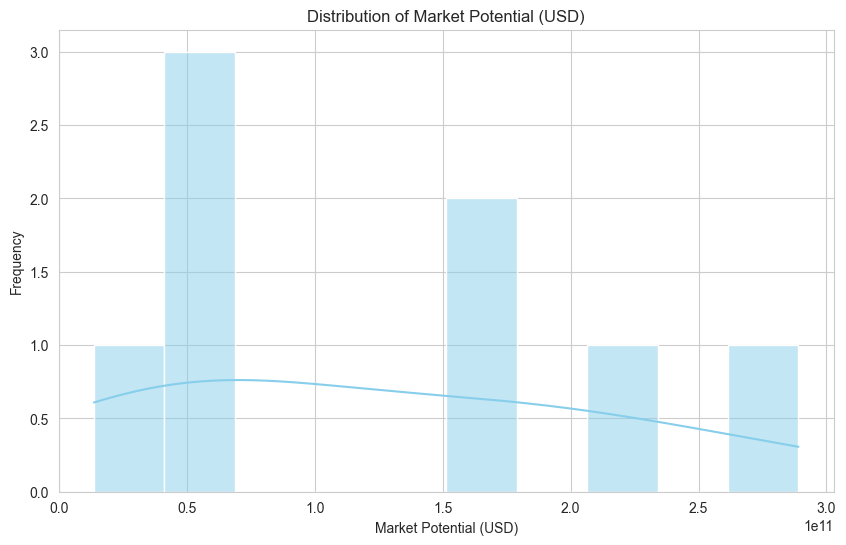

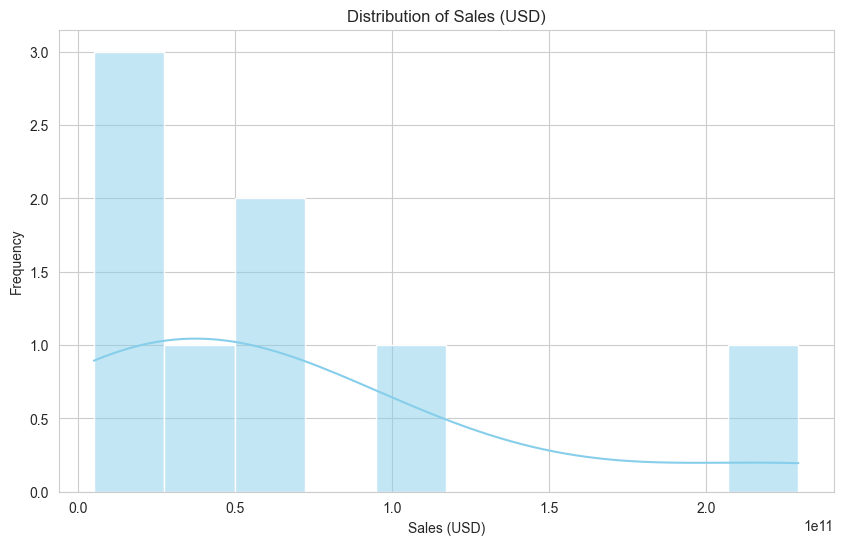

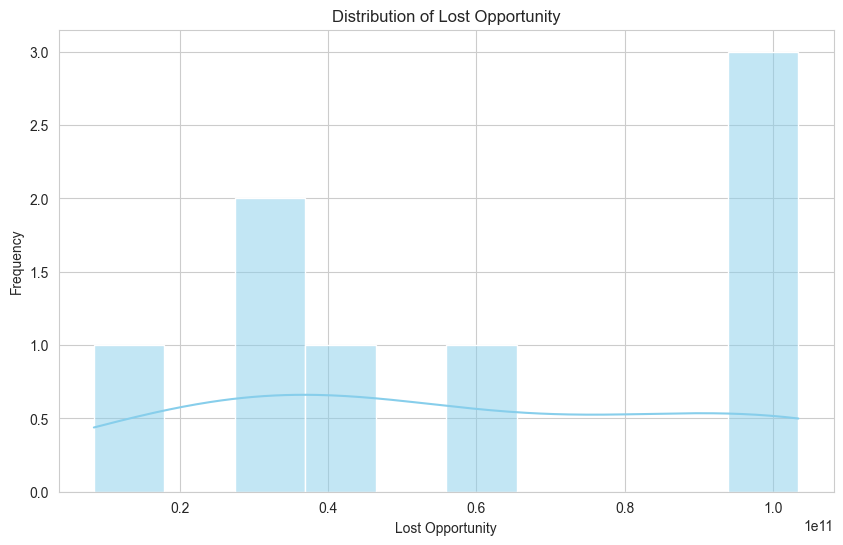

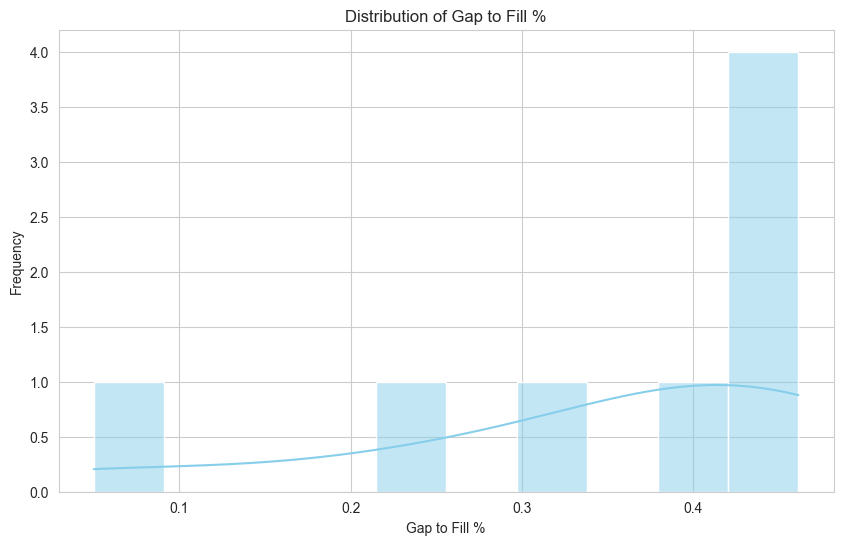

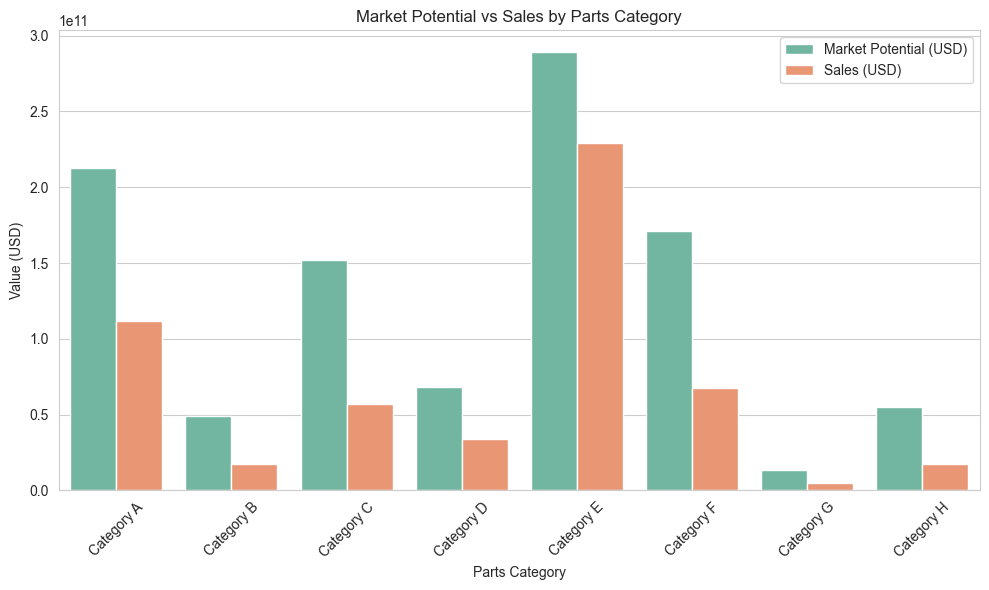

<Figure size 1000x600 with 0 Axes>

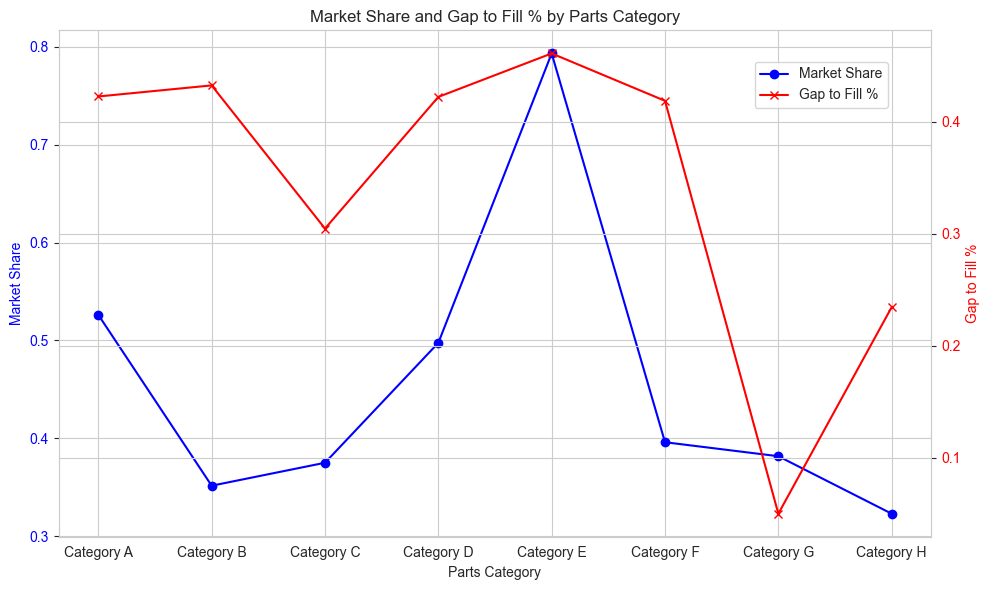

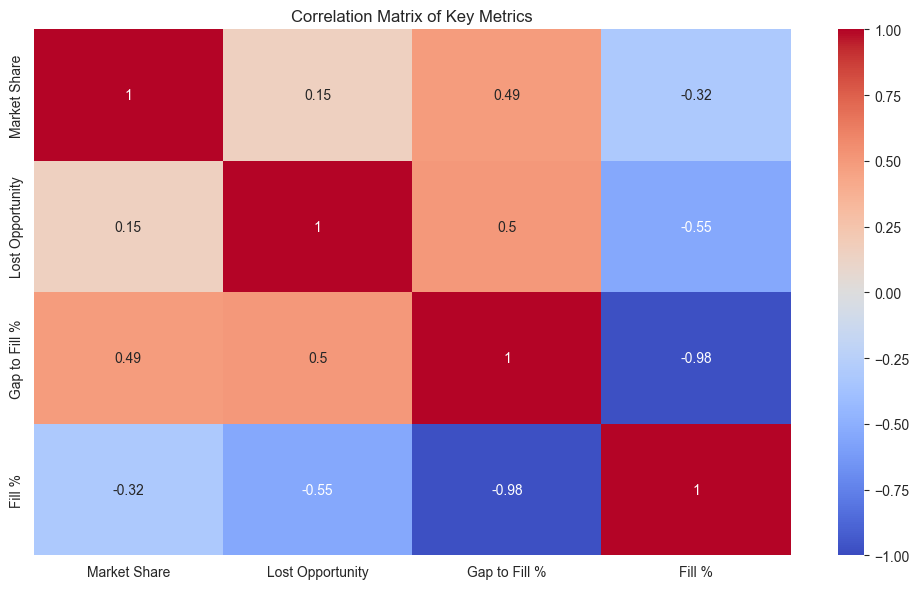

C:\Users\MONISH\AppData\Local\Temp\ipykernel_30176\2381438807.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_data, x='Sales Channel', y='Gap to Fill %', palette='Set3')


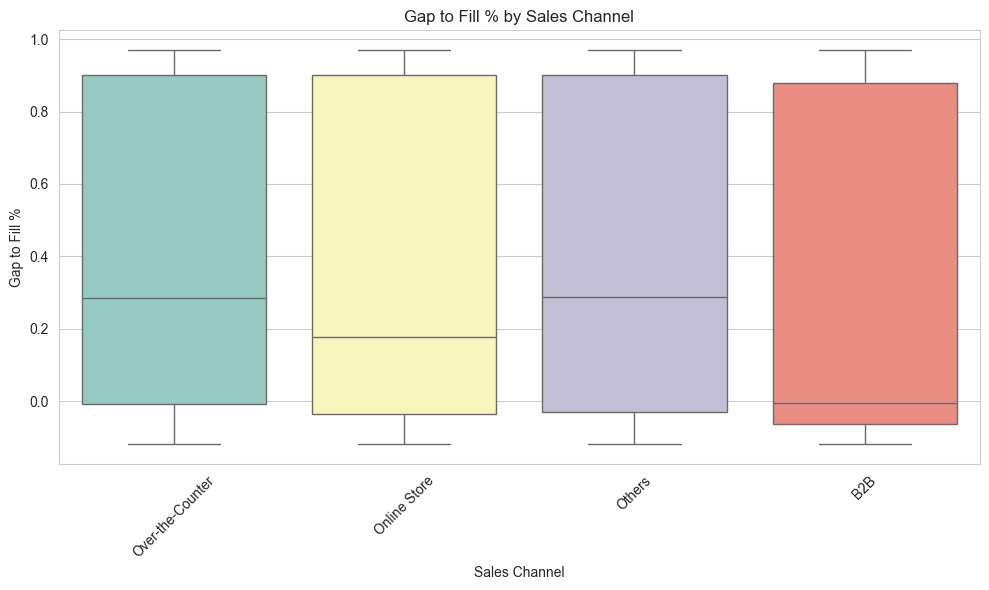

<Figure size 1000x600 with 0 Axes>

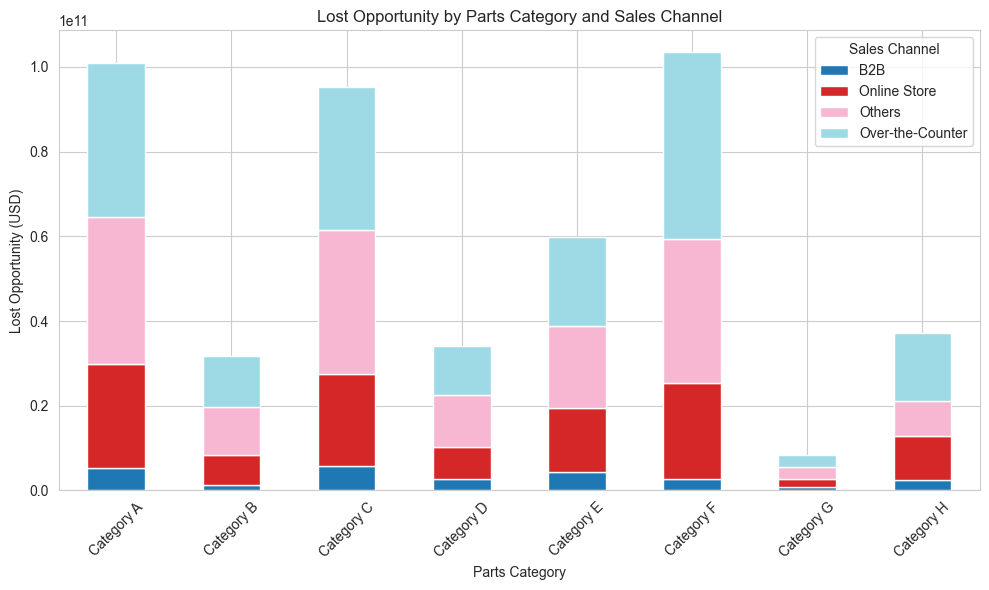

In [6]:
# Distribution of key metrics
for col in ['Market Potential (USD)' , 'Sales (USD)' , 'Lost Opportunity' , 'Gap to Fill %']:
    plt.figure()
    sns.histplot( aggregated_metrics[col], kde=True, bins=10, color='skyblue' )
    plt.title( f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency' )
    plt.show()

# Bar Plot: Market Potential vs Sales
plt.figure()
melted_data = aggregated_metrics.melt (id_vars='Parts Category', value_vars=['Market Potential (USD)', 'Sales (USD)'])
sns.barplot(data=melted_data, x='Parts Category', y='value', hue='variable', palette='Set2')
plt.title('Market Potential vs Sales by Parts Category')
plt.xlabel( 'Parts Category' )
plt.ylabel( 'Value (USD)' )
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Line Plot: Market Share vs Gap to Fill %
plt.figure()
fig, ax1 = plt.subplots()
ax1.plot(aggregated_metrics['Parts Category'], aggregated_metrics['Market Share'], marker='o', color='blue', label='Market Share')
ax1.set_xlabel('Parts Category')
ax1.set_ylabel('Market Share', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(aggregated_metrics['Parts Category'], aggregated_metrics['Gap to Fill %'], marker='x', color='red', label='Gap to Fill %')
ax2.set_ylabel('Gap to Fill %', color='red')
ax2.tick_params(axis='y', labelcolor='red')
plt.title('Market Share and Gap to Fill % by Parts Category')
plt.xticks(rotation=45)
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
plt.tight_layout()
plt.show()



# Correlation Heatmap
plt.figure()
corr_matrix = aggregated_metrics[['Market Share', 'Lost Opportunity', 'Gap to Fill %', 'Fill %']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix of Key Metrics')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
plt.show()




# Box Plot: Gap to Fill % by Sales Channel
plt.figure()
sns.boxplot(data=merged_data, x='Sales Channel', y='Gap to Fill %', palette='Set3')
plt.title('Gap to Fill % by Sales Channel')
plt.xlabel('Sales Channel')
plt.ylabel('Gap to Fill %')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('gap_to_fill_by_channel.png')
plt.show()


# Stacked Bar Plot: Lost Opportunity by Sales Channel and Parts Category
plt.figure()
channel_pivot = merged_data.pivot_table(
    values='Lost Opportunity',
    index='Parts Category',
    columns='Sales Channel',
    aggfunc='sum',
    fill_value=0
)
channel_pivot.plot(kind='bar', stacked=True, colormap='tab20')
plt.title('Lost Opportunity by Parts Category and Sales Channel')
plt.xlabel('Parts Category')
plt.ylabel('Lost Opportunity (USD)')
plt.xticks(rotation=45)
plt.legend(title='Sales Channel')
plt.tight_layout()
plt.savefig('lost_opportunity_by_channel.png')
plt.show()

In [7]:
# Summary Statistics
print("\nSummary Statistics by Parts Category:")
display(aggregated_metrics[['Market Potential (USD)', 'Sales (USD)', 'Market Share', 'Lost Opportunity', 'Gap to Fill %']].describe())


Summary Statistics by Parts Category:


,Market Potential (USD),Sales (USD),Market Share,Lost Opportunity,Gap to Fill %
count,8.000000e+00,8.000000e+00,8.000000,8.000000e+00,8.000000
mean,1.263692e+11,6.751951e+10,0.455486,5.884971e+10,0.343436
std,9.552562e+10,7.395402e+10,0.153387,3.672727e+10,0.141165
min,1.354830e+10,5.170759e+09,0.322916,8.377540e+09,0.050055
25%,5.341666e+10,1.759978e+10,0.369119,3.354928e+10,0.287232
50%,1.101278e+11,4.545662e+10,0.388806,4.845617e+10,0.420659
75%,1.816937e+11,7.887181e+10,0.504647,9.663340e+10,0.425273
max,2.890240e+11,2.292670e+11,0.793246,1.034617e+11,0.461255


### **EDA Insights**:
 - Distributions show the spread of key metrics, with potential skewness in Market Potential and Lost Opportunity.
 - Bar plots highlight gaps between Market Potential and Sales, indicating opportunities.
 - Line plots reveal relationships between Market Share and availability gaps.

## ## Step 5: Bubble Chart Visualization

In [8]:
! pip install adjustText

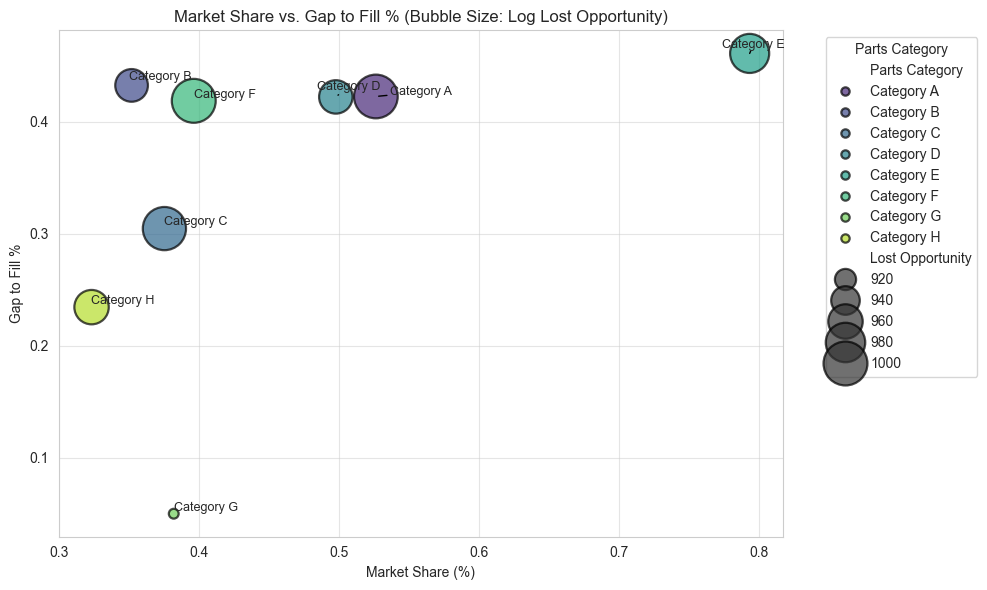

In [9]:
from adjustText import adjust_text
plt.figure()
bubble_sizes = np.log1p(aggregated_metrics['Lost Opportunity']) / np.log1p(aggregated_metrics['Lost Opportunity']).max() * 1000
scatter = sns.scatterplot(
    data=aggregated_metrics,
    x='Market Share',
    y='Gap to Fill %',
    size=bubble_sizes,
    hue='Parts Category',
    sizes=(50, 1000),
    palette='viridis',
    alpha=0.7,
    edgecolor='black'
)
texts = [plt.text(row['Market Share'], row['Gap to Fill %'], row['Parts Category'], fontsize=9) 
         for i, row in aggregated_metrics.iterrows()]
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'))
plt.title('Market Share vs. Gap to Fill % (Bubble Size: Log Lost Opportunity)')
plt.xlabel('Market Share (%)')
plt.ylabel('Gap to Fill %')
plt.legend(title='Parts Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.savefig('bubble_chart_sheets2_4.png')
plt.show()

In [10]:

# Step 5b: Interactive Bubble Chart
fig = px.scatter(
    aggregated_metrics,
    x='Market Share',
    y='Gap to Fill %',
    size='Lost Opportunity',
    color='Parts Category',
    hover_data=['Parts Category', 'Lost Opportunity'],
    size_max=60,
    title='Interactive: Market Share vs. Gap to Fill % (Bubble Size: Lost Opportunity)'
)
fig.update_layout(
    xaxis_title='Market Share (%)',
    yaxis_title='Gap to Fill %',
    legend_title='Parts Category',
    showlegend=True
)
fig.write_html('bubble_chart_interactive.html')
fig.show()

### **Insights**:
 - Categories with large bubbles (high Lost Opportunity) and high Gap to Fill % indicate significant supply constraints.
- Low Market Share with high gaps suggests underperformance in capturing market potential.


## ## Step 6: Simulated Discount Impact

In [11]:
simulated_data = aggregated_metrics.copy()
discount_factor = 0.15
simulated_data['Simulated Sales (USD)'] = simulated_data['Sales (USD)'] * (1 + discount_factor)
simulated_data['Simulated Market Share'] = simulated_data['Simulated Sales (USD)'] / simulated_data['Market Potential (USD)'].replace(0, epsilon)
simulated_data['Simulated Lost Opportunity'] = (simulated_data['Market Potential (USD)'] - simulated_data['Simulated Sales (USD)']).clip(lower=0)

print("\nSimulated Impact of 15% Sales Increase:")
display(simulated_data[['Parts Category', 'Market Share', 'Simulated Market Share', 'Lost Opportunity', 'Simulated Lost Opportunity']])


Simulated Impact of 15% Sales Increase:


,Parts Category,Market Share,Simulated Market Share,Lost Opportunity,Simulated Lost Opportunity
0,Category A,0.526120,0.605038,1.009023e+11,8.409848e+10
1,Category B,0.351521,0.404250,3.180146e+10,2.921566e+10
2,Category C,0.374985,0.431232,9.521042e+10,8.664204e+10
3,Category D,0.497489,0.572112,3.413189e+10,2.906328e+10
4,Category E,0.793246,0.912232,5.975698e+10,2.536693e+10
5,Category F,0.395958,0.455351,1.034617e+11,9.328867e+10
6,Category G,0.381654,0.438902,8.377540e+09,7.601926e+09
7,Category H,0.322916,0.371353,3.715535e+10,3.449733e+10


In [12]:
corr, p_value = pearsonr(aggregated_metrics['Gap to Fill %'], aggregated_metrics['Market Share'])
print(f"\nCorrelation between Gap to Fill % and Market Share: {corr:.4f} (p-value: {p_value:.4f})")



Correlation between Gap to Fill % and Market Share: 0.4892 (p-value: 0.2186)


## ## Step 7: Prioritized Insights

In [13]:
# Top categories by Lost Opportunity
top_lost_opportunities = aggregated_metrics.nlargest(5, 'Lost Opportunity')
print("\nTop Categories by Lost Opportunity:")
display(top_lost_opportunities)


# Formatted Table for Presentation
top_lost_opportunities_styled = top_lost_opportunities[['Parts Category', 'Lost Opportunity', 'Market Share', 'Gap to Fill %']].style.format({
    'Lost Opportunity': '{:,.0f}',
    'Market Share': '{:.2%}',
    'Gap to Fill %': '{:.2%}'
}).set_caption('Top 5 Categories by Lost Opportunity')
top_lost_opportunities_styled.to_html('top_lost_opportunities_table.html')  # Save for presentation
print("\nFormatted Table for Presentation:")
display(top_lost_opportunities_styled)


Top Categories by Lost Opportunity:


,Parts Category,Market Potential (USD),Sales (USD),Market Share,Lost Opportunity,Gap to Fill %,Fill %,Fill % Target
5,Category F,1.712822e+11,6.782051e+10,0.395958,1.034617e+11,0.418907,0.481093,0.90
0,Category A,2.129280e+11,1.120257e+11,0.526120,1.009023e+11,0.422802,0.517198,0.94
2,Category C,1.523329e+11,5.712250e+10,0.374985,9.521042e+10,0.304777,0.575223,0.88
4,Category E,2.890240e+11,2.292670e+11,0.793246,5.975698e+10,0.461255,0.508745,0.97
7,Category H,5.487552e+10,1.772016e+10,0.322916,3.715535e+10,0.234596,0.665404,0.90



Formatted Table for Presentation:


,Parts Category,Lost Opportunity,Market Share,Gap to Fill %
5,Category F,"103,461,742,473",39.60%,41.89%
0,Category A,"100,902,333,624",52.61%,42.28%
2,Category C,"95,210,418,247",37.50%,30.48%
4,Category E,"59,756,978,416",79.32%,46.13%
7,Category H,"37,155,354,064",32.29%,23.46%


#### Step 7b: Pareto Analysis for Lost Opportunity

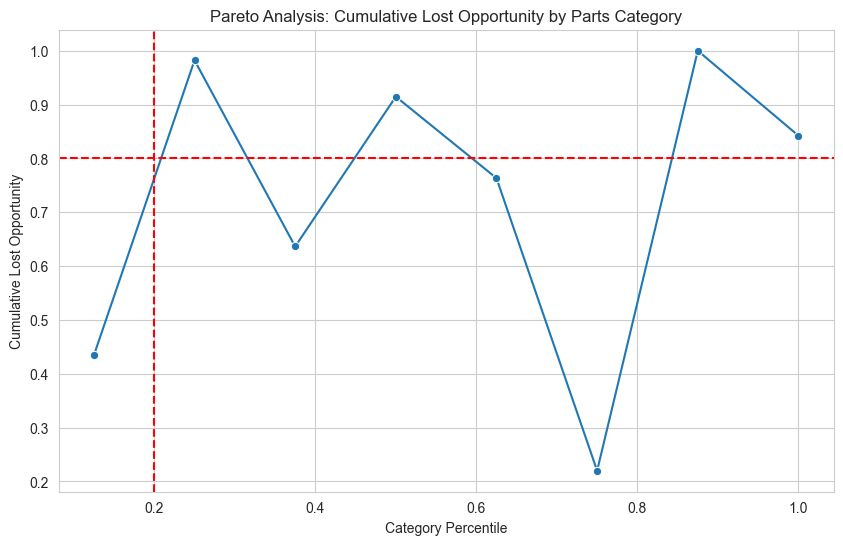


Top 20% Categories by Lost Opportunity:


,Parts Category,Lost Opportunity,Cumulative
0,Category A,1.009023e+11,0.43408


In [ ]:

pareto_data = aggregated_metrics[['Parts Category', 'Lost Opportunity']].sort_values('Lost Opportunity', ascending=False)
pareto_data['Cumulative'] = pareto_data['Lost Opportunity'].cumsum() / pareto_data['Lost Opportunity'].sum()
pareto_data['Category Percentile'] = (pareto_data.index + 1) / len(pareto_data)
top_20_percent = pareto_data[pareto_data['Category Percentile'] <= 0.2]
plt.figure()
sns.lineplot(data=pareto_data, x='Category Percentile', y='Cumulative', marker='o')
plt.axhline(y=0.8, color='r', linestyle='--')
plt.axvline(x=0.2, color='r', linestyle='--')
plt.title('Pareto Analysis: Cumulative Lost Opportunity by Parts Category')
plt.xlabel('Category Percentile')
plt.ylabel('Cumulative Lost Opportunity')
plt.savefig('pareto_lost_opportunity.png')
plt.show()
print("\nTop 20% Categories by Lost Opportunity:")
display(top_20_percent[['Parts Category', 'Lost Opportunity', 'Cumulative']])

<Figure size 1000x600 with 0 Axes>

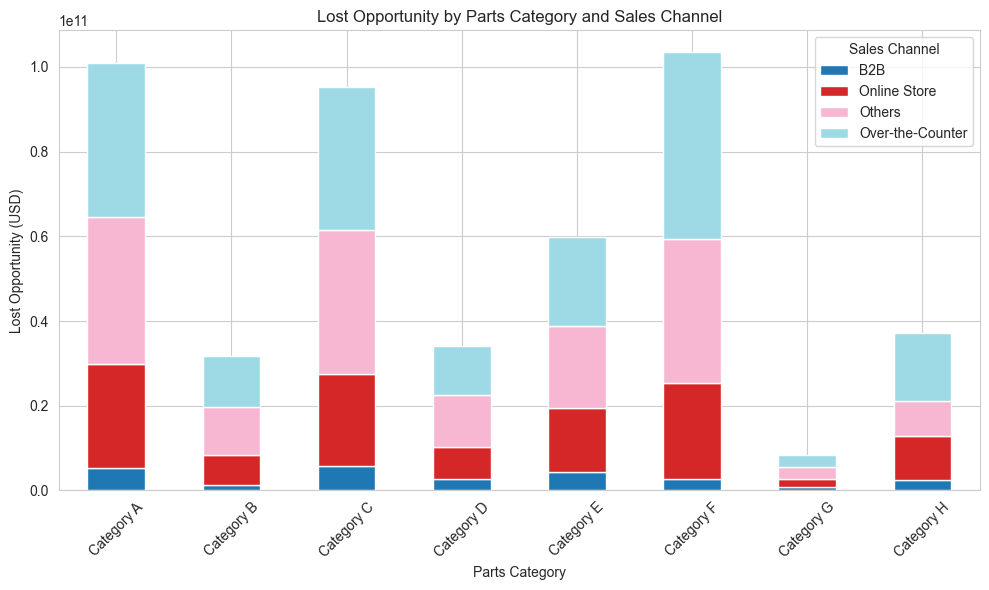

In [15]:
# Stacked Bar Plot: Lost Opportunity by Sales Channel and Parts Category
plt.figure()
channel_pivot = merged_data.pivot_table(
    values='Lost Opportunity',
    index='Parts Category',
    columns='Sales Channel',
    aggfunc='sum',
    fill_value=0
)
channel_pivot.plot(kind='bar', stacked=True, colormap='tab20')
plt.title('Lost Opportunity by Parts Category and Sales Channel')
plt.xlabel('Parts Category')
plt.ylabel('Lost Opportunity (USD)')
plt.xticks(rotation=45)
plt.legend(title='Sales Channel')
plt.tight_layout()
plt.savefig('lost_opportunity_by_channel.png')
plt.show()

K-Means Clustering of Parts Category

Segment parts category into strategic groups based on Market Share, Gap to Fill %, and Lost Opportunity, enabling targeted recommendations.

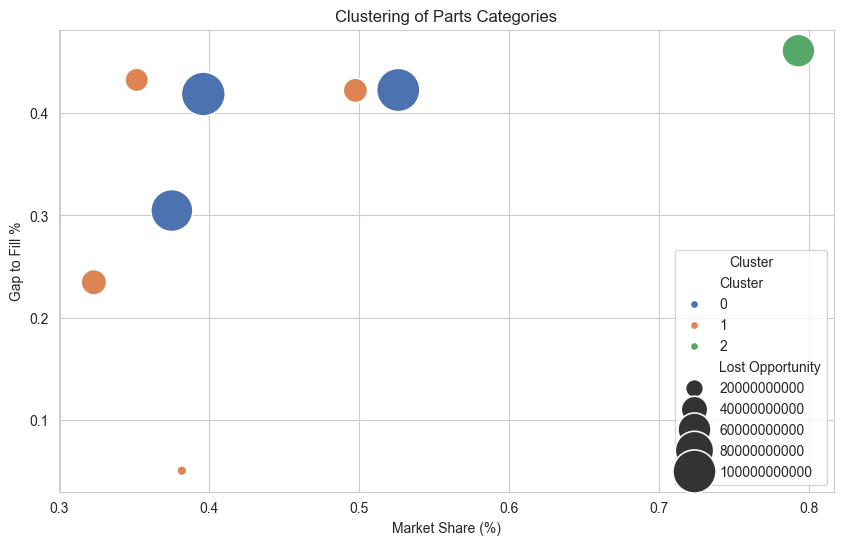


Cluster Summary:


,Market Share,Gap to Fill %,Lost Opportunity,Count
Cluster,,,,
0,0.432354,0.382162,9.985816e+10,3
1,0.388395,0.284937,2.786656e+10,4
2,0.793246,0.461255,5.975698e+10,1


In [16]:
# Step 6b: K-Means Clustering
from sklearn.cluster import KMeans
clustering_data = aggregated_metrics[['Market Share', 'Gap to Fill %', 'Lost Opportunity']]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data)
kmeans = KMeans(n_clusters=3, random_state=42)
aggregated_metrics['Cluster'] = kmeans.fit_predict(scaled_data)
plt.figure()
sns.scatterplot(
    data=aggregated_metrics,
    x='Market Share',
    y='Gap to Fill %',
    hue='Cluster',
    size='Lost Opportunity',
    sizes=(50, 1000),
    palette='deep'
)
plt.title('Clustering of Parts Categories')
plt.xlabel('Market Share (%)')
plt.ylabel('Gap to Fill %')
plt.legend(title='Cluster')
plt.savefig('clustering_parts_categories.png')
plt.show()
print("\nCluster Summary:")
display(aggregated_metrics.groupby('Cluster').agg({
    'Market Share': 'mean',
    'Gap to Fill %': 'mean',
    'Lost Opportunity': 'mean',
    'Parts Category': 'count'
}).rename(columns={'Parts Category': 'Count'}))